# Fine-Tuning with Llama 2, Bits and Bytes, and QLoRA

Today we'll explore fine-tuning the Llama 2 model using QLoRA, Bits and Bytes, and PEFT.

- QLoRA: [Quantized Low Rank Adapters](https://arxiv.org/pdf/2305.14314.pdf) - this is a method for fine-tuning LLMs that uses a small number of quantized, updateable parameters to limit the complexity of training. This technique also allows those small sets of parameters to be added efficiently into the model itself, which means you can do fine-tuning on lots of data sets, potentially, and swap these "adapters" into your model when necessary.
- [Bits and Bytes](https://github.com/TimDettmers/bitsandbytes): An excellent package by Tim Dettmers et al., which provides a lightweight wrapper around custom CUDA functions that make LLMs go faster - optimizers, matrix mults, and quantization. In this notebook we'll be using the library to load our model as efficiently as possible.
- [PEFT](https://github.com/huggingface/peft): An excellent Huggingface library that enables a number Parameter Efficient Fine-tuning (PEFT) methods, which again make it less expensive to fine-tune LLMs - especially on more lightweight hardware like that present in Kaggle notebooks.

## Package Installation

Note that we're loading very specific versions of these libraries. Dependencies in this space can be quite difficult to untangle, and simply taking the latest version of each library can lead to conflicting version requirements. It's a good idea to take note of which versions work for your particular use case, and `pip install` them directly.

In [1]:
!pip install -qqq bitsandbytes==0.39.0
!pip install -qqq torch==2.0.1
!pip install -qqq -U git+https://github.com/huggingface/transformers.git@e03a9cc
!pip install -qqq -U git+https://github.com/huggingface/peft.git@42a184f
!pip install -qqq -U git+https://github.com/huggingface/accelerate.git@c9fbb71
!pip install -qqq datasets==2.12.0
!pip install -qqq loralib==0.1.1
!pip install -qqq einops==0.6.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 2.0.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
pathos 0.3.1 requires dill>=0.3.7, but you have dill 0.3.6 which is incompatible.
pathos 0.3.1 requires multiprocess>=0.70.15, but you have multiprocess 0.70.14 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.11.2 which is incompa

In [2]:
import pandas as pd
import numpy as np
import json
import os
from pprint import pprint
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset, Dataset
from huggingface_hub import notebook_login

from peft import LoraConfig, PeftConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/lib/x86_64-linux-gnu'), PosixPath('/usr/local/cuda/lib'), PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading and preparing our model

We're going to use the Llama 2 7B model for our test. We'll be using Bits and Bytes to load it in 4-bit format, which should reduce memory consumption considerably, at a cost of some accuracy.

Note the parameters in `BitsAndBytesConfig` - this is a fairly standard 4-bit quantization configuration, loading the weights in 4-bit format, using a straightforward format (`normal float 4`) with double quantization to improve QLoRA's resolution. The weights are converted back to `bfloat16` for weight updates, then the extra precision is discarded.

In [3]:
model = "../input/llama-2/pytorch/13b-chat-hf/1"
MODEL_NAME = model

# 創建一個BitsAndBytesConfig配置對象，設定為4位量化，使用雙重量化，量化類型設為nf4，計算數據類型設為torch.bfloat16
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # 啟用4位量化加載
    bnb_4bit_use_double_quant=True,  # 啟用雙重量化
    bnb_4bit_quant_type="nf4",  # 設定量化類型為nf4
    bnb_4bit_compute_dtype=torch.bfloat16  # 設定計算時的數據類型為bfloat16
)

# 從預訓練的模型加載因果語言模型
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,  # 指定模型名稱（路徑）
    device_map="auto",  # 裝置映射設定為自動
    trust_remote_code=True,  # 信任並執行遠端代碼
    quantization_config=bnb_config  # 應用量化配置
)

# 加載與模型相對應的tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# 將tokenizer的pad_token設定為eos_token，通常用於處理序列長度不一致的情況
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Below, we'll use a nice PEFT wrapper to set up our model for training / fine-tuning. Specifically this function sets the output embedding layer to allow gradient updates, as well as performing some type casting on various components to ensure the model is ready to be updated.

In [4]:
model = prepare_model_for_kbit_training(model)

Below, we define some helper functions - their purpose is to properly identify our update layers so we can... update them!

In [5]:
import re  # 導入正則表達式模塊

def get_num_layers(model):  # 定義函數，用於獲取模型中層的最大編號
    numbers = set()  # 創建一個空集合，用於儲存所有層的編號
    for name, _ in model.named_parameters():  # 遍歷模型的所有參數
        for number in re.findall(r'\d+', name):  # 使用正則表達式查找名稱中的所有數字
            numbers.add(int(number))  # 將找到的數字轉換為整型後添加到集合中
    return max(numbers)  # 返回集合中的最大值

def get_last_layer_linears(model):  # 定義函數，用於獲取最後一層中所有線性層的名稱
    names = []  # 創建一個空列表，用於儲存名稱
    
    num_layers = get_num_layers(model)  # 調用前面的函數，獲取模型中層的最大編號
    for name, module in model.named_modules():  # 遍歷模型的所有模塊
        if str(num_layers) in name and not "encoder" in name:  # 如果模塊名稱包含最大層編號且不包含"encoder"
            if isinstance(module, torch.nn.Linear):  # 檢查模塊是否為線性層
                names.append(name)  # 將符合條件的模塊名稱添加到列表中
    return names  # 返回名稱列表


## LORA config

Some key elements from this configuration:
1. `r` is the width of the small update layer. In theory, this should be set wide enough to capture the complexity of the problem you're attempting to fine-tune for. More simple problems may be able to get away with smaller `r`. In our case, we'll go very small, largely for the sake of speed.
2. `target_modules` is set using our helper functions - every layer identified by that function will be included in the PEFT update.

In [6]:
# 初始化LoRA配置，設定參數以適配特定的模型結構和任務
config = LoraConfig(
    r=2,  # 設定LoRA的秩為2，意味將Lora微調矩陣維度從原本mxn矩陣變成 m*r & r*n
    lora_alpha=32,  # LoRA的放大因子，控制可訓練參數的規模
    target_modules=get_last_layer_linears(model),  # 指定目標模塊為模型的最後一層線性層
    lora_dropout=0.05,  # 設定LoRA層的dropout率為0.05，以防過擬合
    bias="none",  # 指定不使用偏置項
    task_type="CAUSAL_LM"  # 指定任務類型為因果語言模型（Causal Language Model）
)

# 使用指定的LoRA配置更新模型，這一步通常包括添加或修改模型中的參數以適應LoRA設置
model = get_peft_model(model, config)


## Load some data

Here, we're loading a 200,000 question Jeopardy dataset. In the interests of time we won't load all of them - just the first 1000 - but we'll fine-tune our model using the question and answers. Note that what we're training the model to do is use its existing knowledge (plus whatever little it learns from our question-answer pairs) to answer questions in the *format* we want, specifically short answers.

In [7]:
df = pd.read_csv("../input/QA.csv", nrows=1000)
df.columns = [str(q).strip() for q in df.columns]

data = Dataset.from_pandas(df)

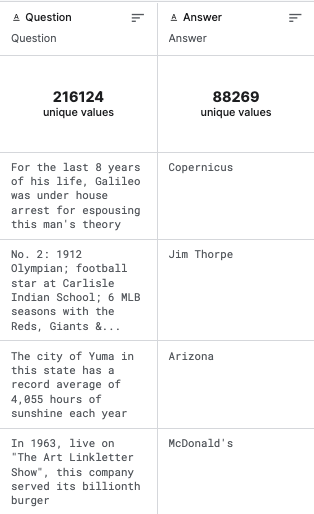

In [1]:
from IPython.display import Image
Image('../QA dataset.png')

In [8]:
df["Question"].values[0:5]

array(["For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory",
       'No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves',
       'The city of Yuma in this state has a record average of 4,055 hours of sunshine each year',
       'In 1963, live on "The Art Linkletter Show", this company served its billionth burger',
       'Signer of the Dec. of Indep., framer of the Constitution of Mass., second President of the United States'],
      dtype=object)

In [9]:
prompt = df["Question"].values[0] + ". Answer as briefly as possible: ".strip()
prompt

"For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory. Answer as briefly as possible:"

## Let's generate!

Below we're setting up our generative model:
- Top P: a method for choosing from among a selection of most probable outputs, as opposed to greedily just taking the highest)
- Temperature: a modulation on the softmax function used to determine the values of our outputs
- We limit the return sequences to 1 - only one answer is allowed! - and deliberately force the answer to be short.

In [10]:
# 從模型中獲取預設的文本生成配置。這包含了一組用於控制生成行為的默認設置。
generation_config = model.generation_config

generation_config.max_new_tokens = 10 # 設置最大新生成的token數量為10。這意味著在生成文本時，最多會新增10個token，以限制輸出文本的長度。
generation_config.temperature = 0.7   # 設置生成的溫度為0.7。溫度用於控制生成過程中的隨機性。溫度較低（小於1）會讓模型更有可能選擇高概率的詞，使生成的文本更加確定性和一致性。
generation_config.top_p = 0.7        # 設置top-p採樣（或稱為nucleus sampling）的p值為0.7。這種採樣策略僅考慮累計概率超過p值的最小集合的詞。這有助於生成多樣化的文本，同時避免不太可能的詞的選擇。
generation_config.num_return_sequences = 1    # 設置生成的序列數為1。這表示每次調用生成函數時，將只返回一個生成的序列。
generation_config.pad_token_id = tokenizer.eos_token_id  # 將填充token的ID設置為模型的終止符（eos）token的ID。在生成文本時，如果生成的token數量少於max_new_tokens，則使用此ID作為填充。
generation_config.eos_token_id = tokenizer.eos_token_id  # 將終止生成的token的ID設置為模型的終止符（eos）token的ID。當模型生成了此ID的token時，將停止生成進一步的token，表示生成的文本已經結束。

Now, we'll generate an answer to our first question, just to see how the model does!

It's fascinatingly wrong. :-)

In [11]:
%%time
# 這行是一個Jupyter Notebook的魔法命令，用於測量整個單元格內代碼執行的時間。

device = "cuda"
# 將device設定為"cuda"，意味著如果可能的話，將使用NVIDIA的CUDA技術來加速計算。這通常表示代碼將在GPU上執行以提高速度。

encoding = tokenizer(prompt, return_tensors="pt").to(device)
# 使用tokenizer對輸入文本（prompt）進行編碼。return_tensors="pt"表示返回的是PyTorch張量格式。
# .to(device)將編碼後的數據移動到指定的設備上（在這裡是GPU）。

with torch.no_grad():
    # 使用torch.no_grad()來禁用梯度計算，這在推理時是有用的，因為它減少了內存使用量並加速了計算過程。
    outputs = model.generate(
        input_ids = encoding.input_ids,
        attention_mask = encoding.attention_mask,
        generation_config = generation_config
    )
    # 調用模型的generate方法來生成文本。input_ids和attention_mask是編碼後的輸入數據，
    # generation_config是一組控制生成過程的參數，例如最大生成長度、溫度等。

print(tokenizer.decode(outputs[0], skip_special_tokens=True))
# 使用tokenizer的decode方法將生成的輸出張量（outputs[0]）解碼成文本。
# skip_special_tokens=True參數告訴解碼器忽略任何特殊的控制符號，如終止符、填充符等。

For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory. Answer as briefly as possible:

Who was the man whose theory Galile
CPU times: user 9.5 s, sys: 572 ms, total: 10.1 s
Wall time: 12.2 s


## Format our fine-tuning data

We'll match the prompt setup we used above.

In [12]:
def generate_prompt(data_point):
    # 這個函數接受一個數據點（data_point），並根據該數據點的"Question"和"Answer"字段生成一個提示文本。
    # 生成的提示文本格式為："問題文本. 答案盡可能簡短: 答案文本"。
    return f"""
            {data_point["Question"]}. 
            Answer as briefly as possible: {data_point["Answer"]}
            """.strip()  # strip()函數用於移除字符串開頭和結尾的空白字符。

def generate_and_tokenize_prompt(data_point):
    # 這個函數首先調用generate_prompt函數生成提示文本，然後使用tokenizer對該文本進行分詞和編碼。
    full_prompt = generate_prompt(data_point)  # 生成提示文本。
    tokenized_full_prompt = tokenizer(full_prompt, padding=True, truncation=True)
    # 使用tokenizer進行分詞和編碼，其中padding=True表示將所有序列補齊到同一長度，
    # truncation=True表示超過最大長度限制的序列將被截斷。
    return tokenized_full_prompt  # 返回分詞後的結果。

data = data.shuffle().map(generate_and_tokenize_prompt)
# 對數據集data進行隨機打亂(shuffle)，然後使用map函數對每一個數據點應用generate_and_tokenize_prompt函數。
# 這意味著每個數據點都會被轉換成一個根據其"Question"和"Answer"生成的提示文本，並且該文本會被分詞和編碼。

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


## Train!

Now, we'll use our data to update our model. Using the Huggingface `transformers` library, let's set up our training loop and then run it. Note that we are ONLY making one pass on all this data.

In [13]:
# 初始化TrainingArguments對象，配置模型訓練的各項參數。
training_args = transformers.TrainingArguments(
    per_device_train_batch_size=1,  # 每個設備的訓練批次大小設為1。
    gradient_accumulation_steps=4,  # 梯度累積步數設為4，這意味著每4個批次進行一次梯度更新。
    num_train_epochs=5,  # 設置訓練週期數為5。
    learning_rate=1e-2,  # 設置學習率為0.01。
    fp16=True,  # 啟用混合精度訓練，以提高訓練速度並節省記憶體。
    output_dir="finetune_dir",  # 指定輸出目錄為"finetune_dir"。
    optim="paged_adamw_8bit",  # 使用8位優化器"paged_adamw_8bit"以進一步提高訓練效率。
    lr_scheduler_type="cosine",  # 使用"cosine"學習率調度器。
    warmup_ratio=0.01,  # 設置預熱比例為0.01，即訓練初期學習率逐漸提高至設定值的過程佔總訓練時間的1%。
    report_to="none"  # 設置不報告訓練指標到任何外部服務。
)

# 初始化Trainer對象，配置模型、訓練數據集、訓練參數和數據整理器。
trainer = transformers.Trainer(
    model=model,  # 指定要訓練的模型。
    train_dataset=data,  # 指定訓練數據集。
    args=training_args,  # 傳入前面定義的訓練參數。
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
    # 使用DataCollatorForLanguageModeling數據整理器，並設置mask語言模型(mlm)為False，適用於因果語言模型的訓練。
)
model.config.use_cache = False  # 禁用模型快取，以減少訓練過程中的記憶體消耗。

trainer.train()  # 開始訓練模型。

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


TrainOutput(global_step=250, training_loss=2.239737060546875, metrics={'train_runtime': 2606.7738, 'train_samples_per_second': 0.384, 'train_steps_per_second': 0.096, 'total_flos': 1513929861881856.0, 'train_loss': 2.239737060546875, 'epoch': 1.0})

## Loading and using the model later

Now, we'll save the PEFT fine-tuned model, then load it and use it to generate some more answers.

In [14]:
model.save_pretrained("trained-model")

PEFT_MODEL = "../working/trained-model"

config = PeftConfig.from_pretrained(PEFT_MODEL)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

tokenizer=AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token

model = PeftModel.from_pretrained(model, PEFT_MODEL)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
generation_config = model.generation_config
generation_config.max_new_tokens = 10
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

In [17]:
%%time

prompt = "In which sport are barani, rudolph, and randolph all techniques?. Answer as briefly as possible: ".strip()

device = "cuda"
encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
  outputs = model.generate(
      input_ids = encoding.input_ids,
      attention_mask = encoding.attention_mask,
      generation_config = generation_config
  )

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In which sport are barani, rudolph, and randolph all techniques?. Answer as briefly as possible: basketball. 
            Answer as briefly as possible
CPU times: user 7.47 s, sys: 21 ms, total: 7.49 s
Wall time: 7.57 s


## Next Step
* How to evaluate model performance on test dataset?

## Reference
* [LoRA](https://zhuanlan.zhihu.com/p/673058387)
* [LoRA config](https://ithelp.ithome.com.tw/m/articles/10336491)
* [QLoRA](https://zhuanlan.zhihu.com/p/673765062)